# Treniranje modela za chatbot Bernard

Ovaj Jupyter notebook predstavlja proces treniranja modela baziranog na transformer tehnologiji.

Rezultat nakon treniranja je model koji generira odgovor na na proizvoljan unos korisnika.

Sama arhitektura modela je velikim dijelom bazirana na [Transformer modelu za razumijevanje jezika](https://www.tensorflow.org/text/tutorials/transformer), te je također velikim dijelom inspirirana sa [Chatbot programom](https://github.com/bryanlimy/tf2-transformer-chatbot) autora Bryan M. Li, doktoranda na sveučilištu u Edinbourghu. 

## O modelu

Kako b postigli razumijevanje ovakvog modela koji koristi transformer, potrebno je prethodno na teoretskoj razini proučiti tematike [generiranja teksta](https://www.tensorflow.org/text/tutorials/text_generation), [mehanizma pažnje](https://www.tensorflow.org/text/tutorials/nmt_with_attention) i [transformera](https://www.tensorflow.org/text/tutorials/transformer).

Transformer model ovdje koristi mehanizam samopažnje - to jest sposobnost da se različite pozicije znakova u nizu koji čini unos obrade tako da se dobije odgovarajući reprezentant tog niza. 
Transformer tako stvara mnogobrojne slojeve koji koriste mehanizam samopažnje potrebne za postizanje odgovarajućeg rezultata. 

Za daljnje modifikacije ovog modela transformera i modifikaciju hiperparametara, preporučam referirati se na poznati članak pod naslovom [Attention is all you need](https://arxiv.org/abs/1706.03762).

Kako bi u opširnije opisali model i proveli treniranje, potrebno je učitati potrebne biblioteke.:

In [1]:
!pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0

from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
#za widgete
import ipywidgets as widgets
from IPython.display import display

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

#supress tensorflow complaining about everything he sees
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Defaulting to user installation because normal site-packages is not writeable
Tensorflow version 2.9.1


## Korištenje GPU jedinica

Kako bi iskoristili brže mogućnosti računanja koje nam pruža GPU (eng. graphic processing unit, hrv. grafička procesna jedinica), možemo iskoristiti iduće ćelije. 

Ukoliko Vaš hardver omogućava korištenje GPU jedinica, preporučeno je se osloniti na njih umjesto na CPU (eng. central processing unit, hrv. centralna procesna jedinica). Postoji više načina [postavljanja GPU-a za uporabu](https://www.tensorflow.org/guide/gpu) i [strategijama za računanje na GPU jedinicama u slučajevima gdje ih ima više](https://www.tensorflow.org/guide/distributed_training).

Provjerimo koliko grafičkih procesnih jedinica nam je dostupno:

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Mguće je prilagoditi program tako da se optimalno distribuirano izvršava na svim dostupnim grafičkim procesnim jedinicama, bez ručne provjere broja dostupnih jedinica. Distribuirano treniranje sa više grafičkih procesnih jedinica moguće je implementirati koristeći jednu od strategija za distribuirano treniranje koje koristi biblioteka Tensorflow.

Za treniranje transformer modela programa Bernard je tako korištena strategija zrcaljenja (eng. mirrored strategy), koja je dovoljno dobra za naše potrebe. Kako bi Tensorflow konstruirao strategiju zrcaljenja, dovoljno je napraviti sljedeći korak:

In [3]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Kako nijedan uređaj nije naveden u argumentu konstruktora strategije, koriste se svi dostupni GPU-ovi. Ako se ne pronađe nijedan GPU, koristit će se dostupan CPU. 

## Hiperparametri

Kako bi treniranje učinili bržim, parametri vezani uz transformer _num_layers_, _d_model_, i _units_ su smanjeni. 
Kako bi ovaj primjer bio jednostavan i brz, ograničavamo maksimalnu duljinu rečenice na MAX_LENGTH=40.

In [4]:
# Maksimalna duljina rečenice
MAX_LENGTH = 40

# Maksimalni broj sample-ova za preprocesirati
MAX_SAMPLES = 250000

# Za dataset
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# Parametri za transformer
NUM_LAYERS = 4
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

# Broj epoha
EPOCHS = 40

# Podaci za treniranje

Set podataka koji ćemo koristiti je [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), koji sadrži više od 220,000 filmskih dijaloga.

Sam dataset se sastoji od datoteka
1. movie_conversations.txt - datoteka koja sadrži listu identifikacijskih ključeva (ID) razgovora
2. movie_lines.txt - datoteka koja sadrži sam tekst razgovora asociranog sa nekim identifikacijskim ključem



In [5]:
path_to_zip = tf.keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
)

path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

Promotrimo sadržaje datoteka. U tu svrhu, prvo definirajmo funkciju koja čita prvih par redaka datoteka.

In [6]:
def read_first_lines(filename, limit):
  result = []
  with open(filename, 'r') as input_file:
    # datoteke su iterabilne
    for line_number, line in enumerate(input_file):
      if line_number > limit:  # line_number počinje u 0
        break
      result.append(line)
  return result

Tako je sadržaj datoteke __movie_lines.txt__ oblika

In [7]:
print(*read_first_lines(path_to_movie_lines,5), sep='\n')

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?

L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.

L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow



A sadržaj datoteke __movie_conversations.txt__ je oblika

In [8]:
print(*read_first_lines(path_to_movie_conversations,5), sep='\n')

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']



## Učitavanje i preprocesiranje podataka

Prvo ćemo definitrati funkciju za preprocesiranje podataka __preprocess_sentence__ . 
Ona preprocesira svaku rečenicu uklanjanjem posebnih znakova u njoj.
Taj proces ima više koraka: 
1. stvara razmak između riječi i interpunkcije iza nje, npr. "he is smart." => "he is smart ."
    
2. produljenje skraćenica (kontrakcija) iz engleskog jezika, npr. "i'm" => "i am"

3. mijenjanje svih znakova koji nisu u skupu (a-z, A-Z, ".", "?", "!", ",") sa znakom razmaka.

In [9]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # korak 1
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # korak 2
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # korak 3
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

Pri treniranju na podacima je potrebno izvesti i dodatno pretprocesiranje podataka: u dokumentima skupa podataka je, uz linijski prikaz podatka, znak "++\$++" korišten kao separator podataka u linijama dokumenta.

Kako bi pravilno učitali podatke za treniranje kao parove filmskih replika, svaki par filmskih replika gdje jedna odgovara na drugu u razgovoru dijelimo na upit (eng. question) i odgovor (eng. answer).

Kako bi dodatno pretprocesirali skup podataka, definiramo funkciju __load_conversations__ . 

In [10]:
def load_conversations():
    # konstruiraj riječnik sa ključem (ID) filmske replike na vrijednost teksta filmske replike
    id2line = {}
    ## učitani tekst datoteke movie_lines.txt razdvoji u listu po linijama teksta 
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()
        
    ## iz svake linije teksta izdvoji informacije
    ### makni \n znak za idući red iz teksta
    ### razdvoji svaku liniju teksta sa obzirom na separator " +++$+++ "
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id2line[parts[0]] = parts[4]

    #izdvoji parove filmskih replika na popis pitanja (eng. questions) i odgovora (eng. answers).
    inputs, outputs = [], []
    ## učitani tekst datoteke movie_conversations.txt razdvoji u listu po linijama teksta 
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()
    ## iz svake linije teksta izdvoji informacije o razgovoru
    ### makni \n znak za idući red iz teksta
    ### razdvoji svaku liniju teksta sa obzirom na separator " +++$+++ "
    ### dohvati razgovor po listi identifikacijskih ključeva filmskih replika
    #### preprocesiraj tekst filmske replike koristeći prethodno definiranu funkciju preprocess_sentence(sentence)
    #### kada je dohvaćen maksimalan definiran broj parova filmskih replika na kojima će se model trenirati, stani
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    
    # vrati skupove pitanja i odgovora
    return inputs, outputs

Sada možemo pozvati funkciju __load_conversations__, te tako dobiti učitane i preprocesirane upite i odgovore.

Dobivene rezultate ćemo spremiti u liste nazvane __questions__ i __answers__.

In [11]:
questions, answers = load_conversations()

In [12]:
print(f"Sample question: {questions[15]}")
print(f"Sample answer: {answers[15]}")

Sample question: there .
Sample answer: where ?


### Tokeniziranje

Proces tokeniziranja unosa se sastoji od idućih koraka:

1. Konstruiramo tokenizer (preslikajte tekst u ID i ID u tekst) koristeći TensorFlow Datasets SubwordTextEncoder.
2. Tokeniziramo svaku rečenicu.

#### Gradnja tokenizera

Konstuiramo tokenizer koristeći tfds (TensorFlow Datasets SubwordTextEncoder) za liste pitanja i odgovora:

In [13]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

In [14]:
print(f"Tokenized sample question: {tokenizer.encode(questions[15])}")

Tokenized sample question: [119, 1]


#### Tokeniziramo svaku rečenicu

Definiramo početni i završni token za označavanje početka i kraja rečenice.

Definiramo varijablu _VOCAB_SIZE_ koja označava veličinu vokabulara tokenizera, sa pribrojenim +2 za "razumijevanje" počtnog i završnog tokena.

In [15]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

Tokeniziranje samo po sebi sadrži iduće korake: 

1. Dodajemo START_TOKEN i END_TOKEN da označimo početak i kraj svake rečenice.
2. Filtriramo rečenicu koja ima više od MAX_LENGTH tokena.
3. Dopunimo tokenizirane rečenice do duljine MAX_LENGTH

Definiramo taj proces u funkciji __tokenize_and_filter__

In [16]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        
        # korak 1
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # korak 2
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # korak 3
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs

Sada završno, primjenom funkcije na liste __questions__ i __answers__ možemo dobiti 

In [17]:
questions, answers = tokenize_and_filter(questions, answers)

Promotrimo sada veličin rječnika i broj primjera.

In [18]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8247
Number of samples: 194612


## Stvaranje tf.data.Dataset

Koristit ćemo [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) za konstruiranje našeg ulaznog cjevovoda kako bismo iskoristili značajke kao što su predmemorija i prefetching kako bismo ubrzali proces treniranja modela.

Transformator je auto-regresivni model: predviđa jedan po jedan dio i koristi svoj dosadašnji izlaz da odluči što dalje.

Tijekom treninga ovaj primjer koristi metodu _teacher-forcing_. 
_Teacher-forcing_ je prosljeđivanje pravog izlaza na sljedeći vremenski korak bez obzira na to što model predviđa u trenutnom vremenskom koraku.

Kako transformator predviđa svaku riječ, samopažnja mu omogućuje da pogleda prethodne riječi u rečenici unosa kako bi bolje predvidio sljedeću riječ.

Kako bi se spriječilo da model dostigne samo očekivani rezultat, model koristi look-ahead masku.

Target je podijeljen na _decoder_inputs_ koji se dodaju kao ulaz u dekoder, i _cropped_targets_ za izračun našeg gubitka i točnosti.

Unosi dekodera koriste prethodni target kao unos. 
Uklanja START_TOKEN sa targeta.

In [19]:
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [20]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Mehanizam pažnje

### Pažnja skalarnog produkta

Autori su verziju generalnog mehanizma pažnje korištene u originalnoj arhitekturi transformer modela nazvali pažnjom skalarnog produkta (eng. \textit{scaled dot-product attention}). 

Funkcija pažnje koji koristi neuronska mreža transformer tako uzima tri ulaza: vrijednost upita $q$, vektor ključeva $\overrightarrow{k}$ dimenzije $d_k$ i vektor vrijednosti $\overrightarrow{v}$ dimenzije $d_v$. Vrijednost pondera $\alpha_j$ vrijednosti $v_j$, gdje je $j \in \{ 1, \dots , d_v \} $, tako računamo kao primjenu $softmax()$ funkcije na skalarni umnožak upita $q$ sa vektorom $\overrightarrow{k}$ svih ključeva podijeljen sa vrijednosti $\sqrt{d_k}$. Skalarni umnožak upita i vektora ključeva se dijeli sa korijenom dimenzije $d_k$ jer za velike dimenzije vektora ključa skalarni umnožak postaje ogroman, što čini $softmax_k()$ funkciju manje preciznom.

$$\alpha_{j}=softmax_k(\frac{q\overrightarrow{k}^T}{\sqrt{d_k}}), \qquad \text{gdje je} \; j \in \{ 1, \dots , d_v \} $$

Pa bi funkcija pažnje izgledala kao: 
$$Attention(q, \overrightarrow{k}, \overrightarrow{v})=\sum^{d_v}_{i=1}\alpha_{j}v_j, \qquad \text{gdje je} \; j \in \{ 1, \dots , d_v \} $$

U praksi, račun težina se izvodi tako da se funkcija pažnje izvodi na mnogo upita istovremeno. Izrazimo li tako niz upita kao matricu $Q$, te vektore ključeva i pripadnih vrijednosti kao matrice $K$ i $V$ redom, za račun funkcije pažnje možemo izraziti i kao: 

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Kako bi se programski implementirao mehanizam pažnje skalarnog produkta, u programu se definira pomoćna funkcija `scaled_dot_product_attention(query, key, value, mask)`.

Sa obzirom da smo pri izradi chatbot programa za normalizaciju unosa koristili tokene za popunjavanje, potrebno ih je nulirati prije računa mehanizma pažnje. Kako bi nulirali takve ćelije, korisno je primjetiti da su veliki negativni ulazi u funkciju $softmax()$ blizu nule u izlazu.

Maska se tako množi sa iznosom $-1e9$ (što je blizu negativne beskonačnosti). To je učinjeno jer se maska zbraja s skaliranim matričnim množenjem $\frac{QK^T}{\sqrt{d_k}}$ i primjenjuje se neposredno prije ulaza u funkciju $softmax()$.

In [21]:
def scaled_dot_product_attention(query, key, value, mask):
    """Izračunaj težinske vrijednosti pažnje"""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # skaliraj matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # dodajte masku za nuliranje tokena za popunjavanje
    if mask is not None:
        logits += mask * -1e9

    # softmax je normaliziran na zadnjoj osi (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Pažnja s više glava

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="pozornost s više glava">


Pažnja s više glava sastoji se od četiri dijela:

* Linearnih slojeva podijeljenih u glave - Svaki blok pažnje s više glava dobiva tri ulaza: upit $Q$, ključ $K$ i vrijednost $V$. Oni su ulazi linearnih (eng. `Dense`) slojeva neuronske mreže, i dijele na više „glava”.Umjesto jedne glave pozornosti, "upit", "ključ" i "vrijednost" su podijeljeni u više glava jer to omogućuje modelu da zajedno prati informacije na različitim pozicijama iz različitih reprezentativnih prostora. 


* Pažnju skalarnog produkta - Nakon podjele ulaznih vrijednosti, svaka „glava” je smanjene dimenzije, pa je ukupni trošak izračuna mehanizma pažnje isti kao račun mehanizma pažnje sa samo jednom glavom pune dimenzionalnosti. Gore definirana funkcija `scaled_dot_product_attention(query, key, value, mask)` se primjenjuje na svaku glavu zasebno. Pri svakom koraku mehanizma pažnje se mora koristiti odgovarajuća maska. 


* Konkatenciju izlaznih vrijednosti glava - Izlazi mehanizma pažnje za svaku glavu se zatim konkateniraju (pomoću `tf.transpose` i `tf.reshape`).


* Završni linearni sloj - Vrijednost konkatenacije izlaznih vrijednostnih glava zatim prolazi kroz završni, linearni (eng. `Dense`) sloj.

In [22]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer

### Maskiranje

`create_padding_mask` i `create_look_ahead` pomoćne su funkcije za stvaranje maski za maskiranje podstavljenih tokena, te ćemo pomoćne funkcije koristiti kao slojeve `tf.keras.layers.Lambda`.

Maskirajte sve tokene podloška (vrijednost `0`) u seriji kako biste osigurali da model ne tretira podmetanje kao ulaz.

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

Maska unaprijed za maskiranje budućih tokena u nizu.
Također maskiramo pad tokene.

tj. Za predviđanje treće riječi koristit će se samo prva i druga riječ

In [25]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Pozicijsko kodiranje

Budući da ovaj model ne sadrži nikakvo ponavljanje ili konvoluciju, dodano je poziciono kodiranje kako bi se modelu dale neke informacije o relativnom položaju riječi u rečenici.

Pozicijski vektor za kodiranje dodaje se vektoru za ugradnju. Ugrađivanja predstavljaju token u d-dimenzionalnom prostoru gdje će tokeni sa sličnim značenjem biti bliži jedni drugima. Ali ugradnje ne kodiraju relativni položaj riječi u rečenici. Dakle, nakon dodavanja pozicionog kodiranja, riječi će biti bliže jedna drugoj na temelju *sličnosti njihovog značenja i njihovog položaja u rečenici*, u d-dimenzionalnom prostoru.

Formula za izračunavanje položajnog kodiranja je sljedeća:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [27]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

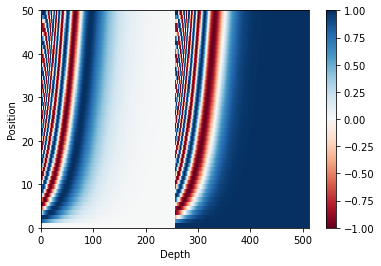

In [28]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### Sloj enkodera 

Svaki sloj enkodera sastoji se od podslojeva:

1. Pažnja za više glava (s podstavljenom maskom)
2. 2 gusta sloja nakon čega slijedi ispadanje

Svaki od ovih podslojeva ima zaostalu vezu oko sebe nakon koje slijedi normalizacija sloja. Preostale veze pomažu u izbjegavanju problema s nestajanjem gradijenta u dubokim mrežama.

Izlaz svakog podsloja je `LayerNorm(x + Sublayer(x))`. Normalizacija se vrši na osi `d_model` (zadnja).

In [29]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Enkoder

Enkoder se sastoji od:
1. Ugradnja unosa
2. Pozicijsko kodiranje
3. `num_layers` slojevi kodera

Ulaz se stavlja kroz ugrađivanje koje se zbraja s pozicijskim kodiranjem. 
Izlaz ovog zbrajanja je ulaz u slojeve kodera. 
Izlaz kodera je ulaz u dekoder.

In [30]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Sloj dekodera

Svaki sloj dekodera sastoji se od podslojeva:

1. Maskirana pažnja s više glava (s maskom za pogled unaprijed i maskom za podstavu)
2. Pažnja za više glava (s podstavnom maskom). `vrijednost` i `ključ` primaju *izlaz kodera* kao ulaze. `upit` prima *izlaz iz maskiranog podsloja pažnje s više glava.*
3. 2 gusta sloja nakon čega slijedi ispadanje

Svaki od ovih podslojeva ima zaostalu vezu oko sebe nakon koje slijedi normalizacija sloja. Izlaz svakog podsloja je `LayerNorm(x + Sublayer(x))`. Normalizacija se vrši na osi `d_model` (zadnja).

Kako `query` prima izlaz iz prvog bloka pozornosti dekodera, a `key` prima izlaz kodera, težine pažnje predstavljaju važnost koja se pridaje ulazu dekodera na temelju izlaza kodera. Drugim riječima, dekoder predviđa sljedeću riječ gledajući izlaz kodera i samostalno prateći svoj izlaz. Pogledajte gornju demonstraciju u odjeljku pozornosti na skalirani točkasti proizvod.

In [31]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Dekoder

Dekoder se sastoji od:
1. Ugradnja izlaza
2. Pozicijsko kodiranje
3. N slojeva dekodera

Cilj se stavlja kroz ugrađivanje koje se zbraja s položajnim kodiranjem. 
Izlaz ovog zbrajanja je ulaz u slojeve dekodera. 
Izlaz dekodera je ulaz u konačni linearni sloj.

In [32]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Transformer

Transformer se sastoji od enkodera, dekodera i završnog linearnog sloja. Izlaz dekodera je ulaz u linearni sloj i njegov se izlaz vraća.


In [33]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Treniranje modela


### Funkcija gubitka (loss function)

Budući da su ciljne sekvence dopunjene, važno je primijeniti masku dopune pri izračunavanju gubitka.

In [34]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Prilagođena stopa učenja

Upotrijebljen je Adamov optimizator s prilagođenim planerom brzine učenja prema formuli u [radu](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

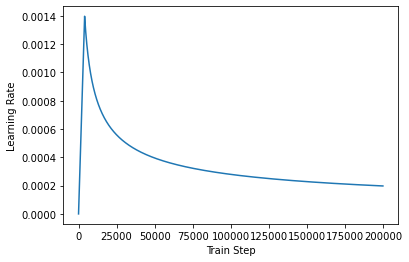

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Inicijalizirajmo i kompajlirajmo model s našom unaprijed definiranom prilagođenom stopom učenja i uključenim Adam optimizatorom.

In [37]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

Za korištenje strategije pri treniranju modela je dovoljno inicijalizirati i kompilirati objekt model
unutar opsega strategije strategy.scope().

In [38]:
with strategy.scope():

    #inicijalizacija modela 
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    #kompilacija modela
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Sada pozovimo metodu model.summary() za ispis korisnog sažetka modela koji uključuje sljedeće:

- Naziv i vrstu svih slojeva modela.

- Izlazni obrazac za svaki sloj.

- Broj težinskih parametara za svaki sloj.

- Ako model ima opću topologiju, ulazi koje svaki sloj prima.

- Ukupan broj parametara modela koji se mogu trenirati i koji se ne mogu trenirati.

In [39]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    10534400    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

Transformer se trenira sa jednostavnim pozivom `model.fit()` funkcije.

In [40]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


3041/3041 [==============================] - 315s 100ms/step - loss: 1.5717 - accuracy: 0.0742
Epoch 2/40
3041/3041 [==============================] - 304s 100ms/step - loss: 1.3711 - accuracy: 0.0872
Epoch 3/40
3041/3041 [==============================] - 304s 100ms/step - loss: 1.3252 - accuracy: 0.0904
Epoch 4/40
3041/3041 [==============================] - 304s 100ms/step - loss: 1.2956 - accuracy: 0.0925
Epoch 5/40
3041/3041 [==============================] - 304s 100ms/step - loss: 1.2757 - accuracy: 0.0940
Epoch 6/40
3041/3041 [==============================] - 303s 100ms/step - loss: 1.2585 - accuracy: 0.0953
Epoch 7/40
3041/3041 [==============================] - 303s 100ms/step - loss: 1.2438 - accuracy: 0.0964
Epoch 8/40
3041/3041 [==============================] - 303s 100ms/step - loss: 1.2320 - accuracy: 0.0973
Epoch 9/40
3041/3041 [==============================] - 304s 100ms/step - loss: 1.2208 - accuracy: 0.0981
Epoch 10/40
3041/3041 [==============================] - 

Sada natrenirani model spremimo.

In [ ]:
tf.keras.models.save_model(model, filepath="model.h5", include_optimizer=False)